## Crazyflie Simulator: LQG 

States is a 3DOF state vector. Rotations are around the body y-axis, positions and velocities in world coordinates, and angular velocity in body-attached rotated coordinates. 

#### boilerplate import code

In [1]:
%config InlineBackend.figure_format='retina' # make plots high resolution

import matplotlib.pyplot as plt
import numpy as np
# debugging: insert a BK() in your code to pause execution there and get a prompt
# in debugging environment (PDB), you can enter normal python commands and see output, with 
# exception for these single-character commands: (q)uit, (c)ontinue, (s)tep into, (n)ext line, (u)p
# NOTE: if you try to run a different cell while in the debugger you will have to Kernel...Restart 
import pdb; BK = pdb.set_trace

import control as ct
# matlab-like structs for convenient access:
class Bunch(): pass 

#### constants

In [3]:
dt = 1/2000.

p = Bunch() # parameters bunch
p.h = 0.01 # height of body [m]
p.l = 0.06 # length of body [m]
p.J = 1.7e-5 # estimate [kgm^2] http://mikehamer.info/assets/papers/Crazyflie%20Modelling.pdf 
p.m = 30e-3 #mass [kg]
p.g = 9.81 # [ms^-2]
p.b = 6.6e-3 # air drag [Nsm^-1]
p.pos_desired = np.array((.01, 0.8)) # [x_world, z_world]
p.sensor_noise_std = np.array((.005, .002, .05)) # [gyro, time-of-flight, optic flow]

#### Simulation: (full, nonlinear) dynamics and sensor functions
The main dynamics function returns the derivative of the state vector at each time step. 

In [4]:
def R(theta):
    # 2D rotation matrix, vworld = R @ vbody and vbody = R.T @ vworld
    return np.array((( np.cos(theta), np.sin(theta)), 
                     (-np.sin(theta), np.cos(theta)))) 
def dynamics(q, u, p):
    thetay = q[0]
    thetadoty = q[1]
    v_world = q[[3, 5]]
    
    # forces in world frame: [f_x, f_z] 
    f_g = (0, -p.m * p.g) # gravity
    f_z = R(thetay) @ (0, u[0] + p.m * p.g) 
    f_d = -p.b * v_world
    f = f_g + f_z + f_d
    
    # torques around body y-axis: [tau_y]
    tauy = u[1] 

    # calculate derivatives
    thetadotdoty = 1/p.J * (tauy - 0) # in 3D this would be J*thetadotdoty = tau - omega x J omega
    vdot = 1/p.m * f
    qdot = np.array((thetadoty, thetadotdoty, v_world[0], vdot[0], v_world[1], vdot[1]))
    return qdot

def sensor_model(q, p):
    thetay = q[0]
    omegay = q[1]
    v_world = q[[3, 5]]
    z = q[4]
    v_body = R(thetay).T @ v_world
    
    ### fill this in ... use np.random.randn() * noise_stddev to add white noise to sensor readings
    gyro = omegay + np.random.randn()*p.sensor_noise_std[0]
    ToF = (z / np.cos(thetay)) + np.random.randn()*p.sensor_noise_std[1]
    OF = omegay - (v_body[0] * np.cos(thetay) / z) + np.random.randn()*p.sensor_noise_std[2]
    ###
    
    return np.array((gyro, ToF, OF))

#### Controllers and estimators
first create linearized dynamics and observer model (matrices)

In [5]:
     # thetay,omega, x,      vx, z,vz
A = np.array([[0,    1, 0,       0, 0, 0], # thetay 
              [0,    0, 0,       0, 0, 0], # omega
              [0,    0, 0,       1, 0, 0], # x
              [p.g,  0, 0,-p.b/p.m, 0, 0], # vx
              [0,    0, 0,       0, 0, 1], # z
              [0,    0, 0,       0, 0, -p.b/p.m]])# vz
B = np.array([[0,     0], 
              [0, 1/p.J], 
              [0,     0],
              [0,     0], 
              [0,     0],
              [1/p.m, 0]])
C = np.array([[0,     1,  0,                  0,   0,     0], # gyro
              [0,     0,  0,                  0,   1,     0], # ToF (time-of-flight)
              [0,     1,  0,-1/p.pos_desired[1],   0,     0]])# OF (optic flow)

In [6]:
observability_matrix_rank = np.linalg.matrix_rank(ct.obsv(A, C))
print(observability_matrix_rank)

if observability_matrix_rank != 6:
    print("System is not observable")

5
System is not observable


LQR controller

In [7]:
QQ = np.diag([1, 10, 1000, 1000, 10, 10]) #  [ty, tdoty, x, vx, z, vz]
RR = np.diag([1e2, 1e12]) # control cost [thrustz, tauy]
K = ct.lqr(A, B, QQ, RR)[0]

def lqr_controller(q, p, t):
    q_desired = np.array((0, 0, p.pos_desired[0], 0, p.pos_desired[1], 0)) # desired trajectory (could be time-varying)
    q_error = q_desired - q
    u = K @ q_error
    u[0] = np.clip(u[0],-0.5*p.m*p.g, 0.5*p.m*p.g) # limit maximum thrust
    return u

Kalman filter/estimator

In [8]:
# first we must create a "reduced" linearized model that does not include x_world 
# in the state because it is not strictly observable
# state:[thetay,omega,      vx, z, vz]
A_r = np.array([[0,    1,       0, 0, 0], # thetay 
                [0,    0,       0, 0, 0], # omega
                [p.g,  0,-p.b/p.m, 0, 0], # vx
                [0,    0,       0, 0, 1], # z
                [0,    0,       0, 0, -p.b/p.m]]) # vz
G_r = np.array([[0,     0,     0], 
                [0,     0,     1/p.J], 
                [1/p.m, 0,     0],
                [0,     0,     0], 
                [0,     1/p.m, 0]])
C_r = np.array([[0,     1,                   0,   0,     0],
                [0,     0,                   0,   1,     0],
                [0,     1, -1/p.pos_desired[1],   0,     0]])

# check observability
### fill this in ...
observability_matrix_rank = np.linalg.matrix_rank(ct.obsv(A, C))
print(observability_matrix_rank)

if observability_matrix_rank == 5:
    print("System is observable")
###

# process noise is your tuning knob. increase it to rely more on sensors

### fill this in 
QN = np.diag([p.m, p.m, p.J])**2/100 # [fx, fz, tauy]
###

p.sensor_noise_std = np.array((.005, .002, .05))
RN = np.diag((p.sensor_noise_std)**2) # sensor noise
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
# print(L)

# now create full estimator, which estimates x_world by numerically integrating vx_body
# the noisy velocity estimate means there will be drift in x_world estimate
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix
# print(L)
G = np.vstack((G_r[:2,:], [0,0,0], G_r[2:,:])) # add a row of zeros to L matrix

5
System is observable


#### Simulation
Simulation is a fixed-step numerical integrator. 

Case 1:

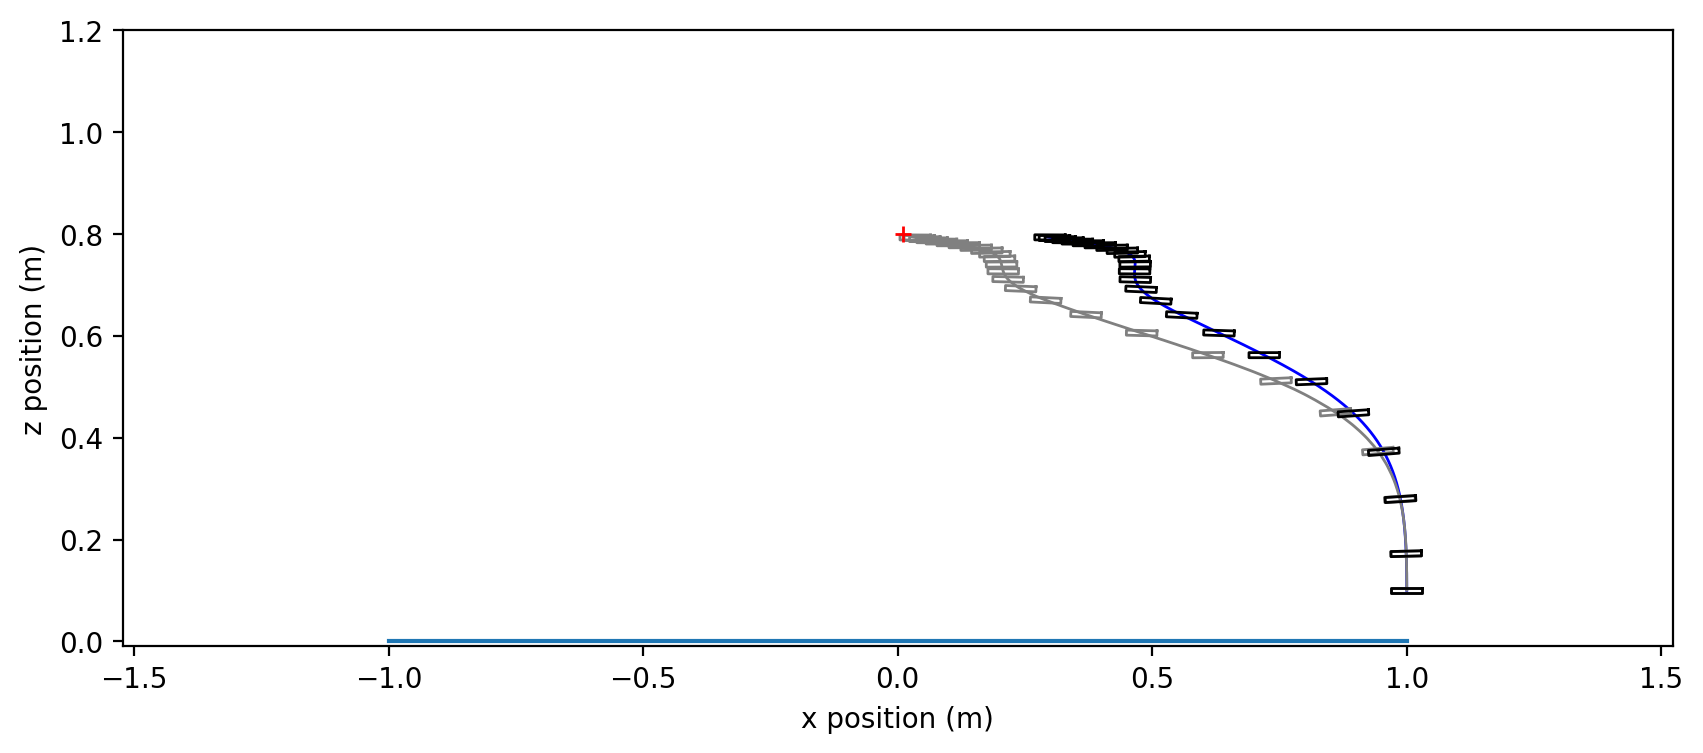

In [9]:
# initialize state and data logs 
q = np.array([0, 0, 1, 0, .1, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    
    ### fill this in
    y = sensor_model(q, p)
#     u = lqr_controller(q, p, t)
    u = lqr_controller(qhat, p, t)
    qhatdot = A @ qhat + B @ u + (L @ (y - C @ qhat)) # Kalman Filter estimate dynamics
    qhat = qhat + dt * qhatdot
    q = q + dt * dynamics(q, u, p)
    ###
    
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat

def plotfly(x, z, theta, p, color='k'):
    h = p.l/2; v = p.h/2 
    points = np.array(((h, h, -h, -h, h), (v, -v, -v, v, v)))
    rotated_points = R(theta) @ points 
    plt.plot(rotated_points[0,:] + x, rotated_points[1,:] + z, color=color, lw=1)
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

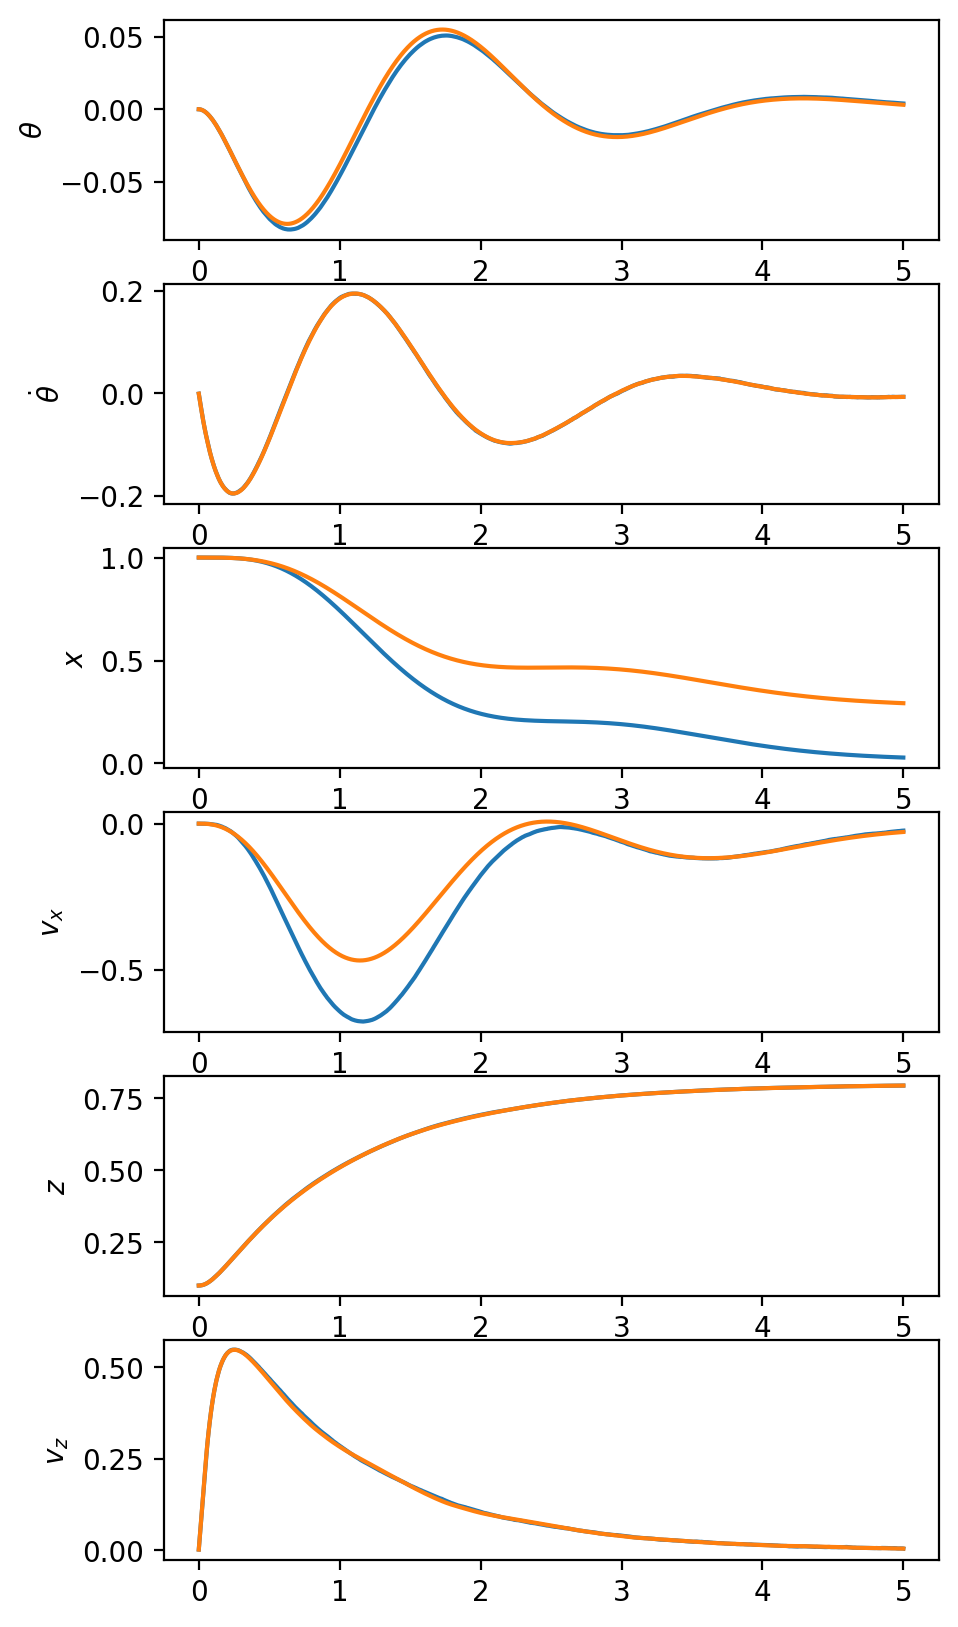

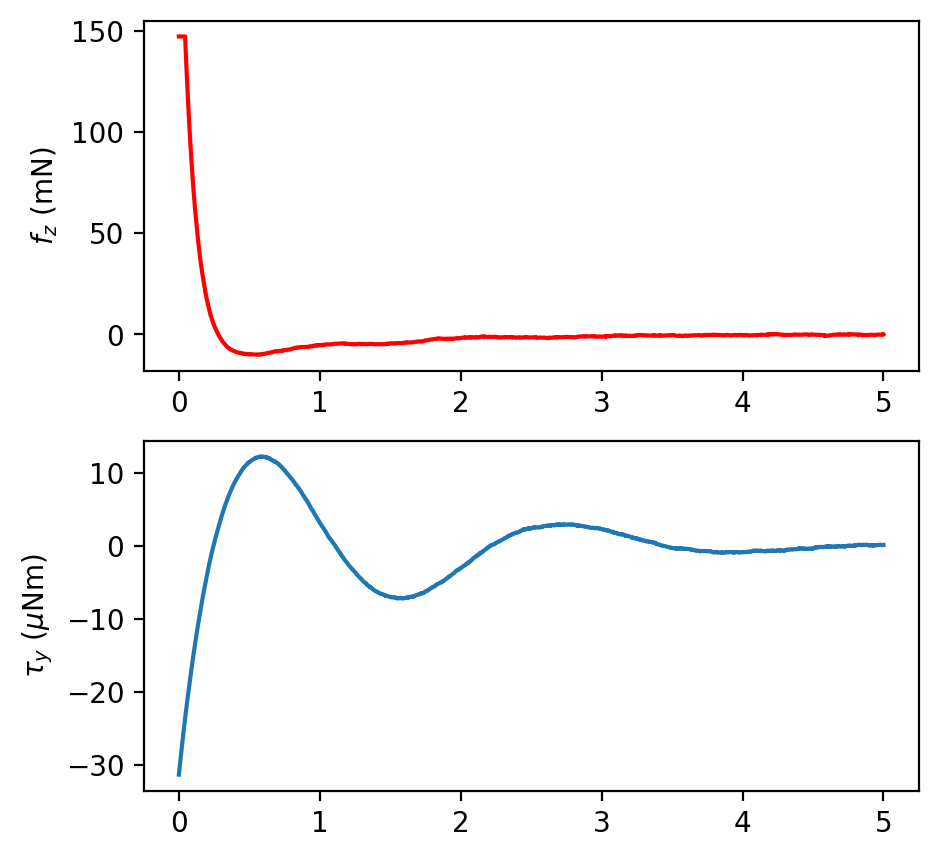

In [11]:
plt.figure(figsize=(5,10))
ylabels = (r'$\theta$', r'$\dot\theta$', r'$x$', r"$v_x$", r'$z$', r"$v_z$")
for idx in range(6):
    plt.subplot(6,1,idx+1)
    plt.plot(time, qhat_data[:,idx], time, q_data[:,idx])
    plt.ylabel(ylabels[idx])

plt.figure(figsize=(5,5))
f_z, tau_y = u_data.T
ylabels = (r'$f_z$ (mN)', r'$\tau_y$ ($\mu$Nm)')
plt.subplot(2,1,1)
plt.plot(time, u_data[:,0]*1e3, 'r')
plt.ylabel(ylabels[0])
plt.subplot(2,1,2)
plt.plot(time, u_data[:,1]*1e6)
plt.ylabel(ylabels[1]);

Case 2: More x-disturbance noise than before but same amount of z disturbance noise. More noise in the vz estimate because of it more reliance on sensor feedback. 

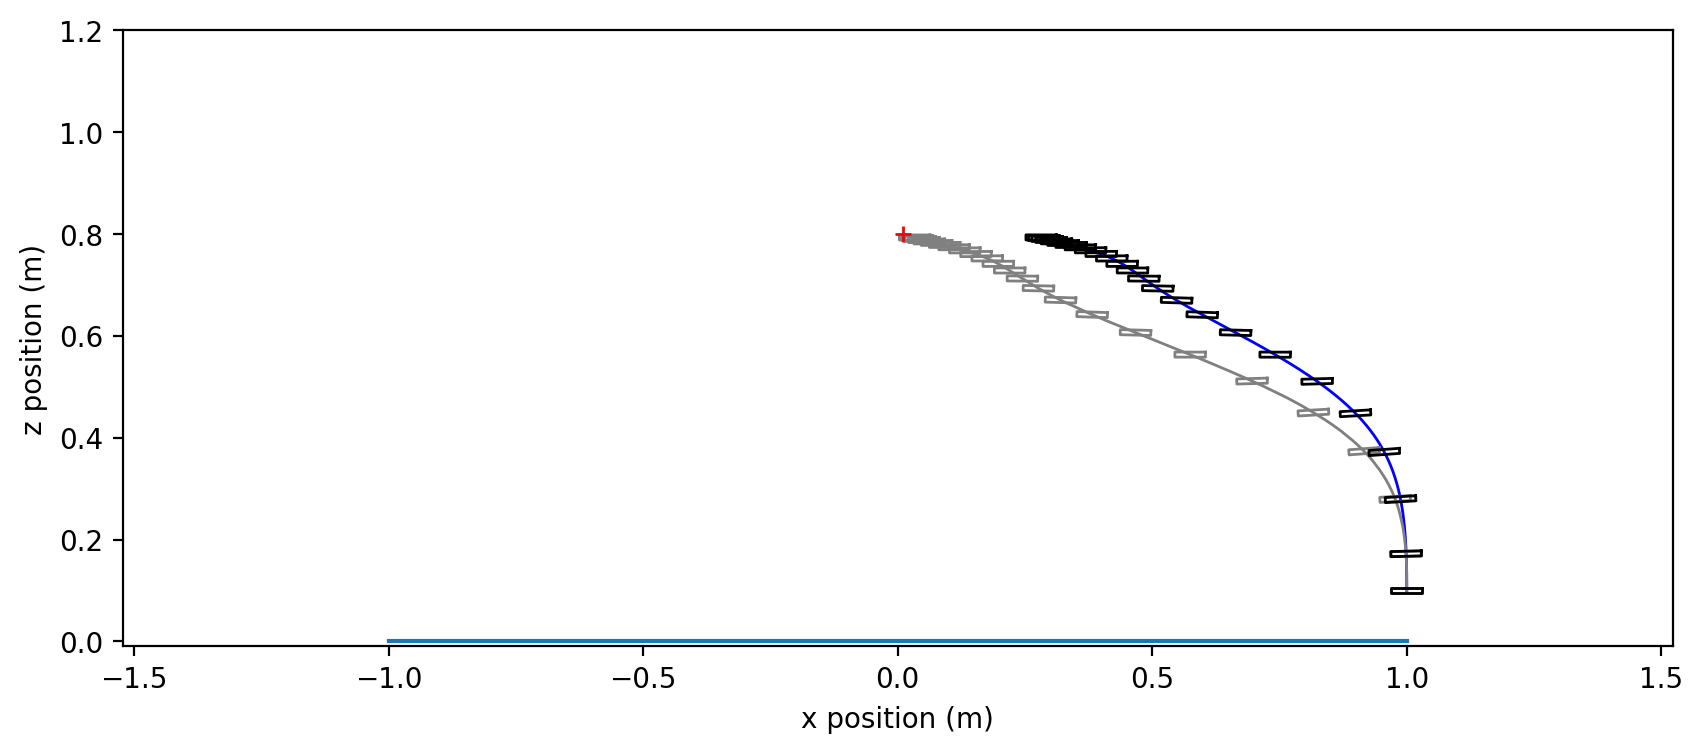

In [13]:
# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag([p.m*75, p.m, p.J])**2/100 # [fx, fz, tauy]
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

# initialize state and data logs 
q = np.array([0, 0, 1, 0, .1, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    y = sensor_model(q, p)
    qhat = qhat + dt * (A @ qhat + B @ u + L @ (y - C @ qhat))
    #u = lqr_controller(q, p, t)
    u = lqr_controller(qhat, p, t)
    q = q + dt * dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

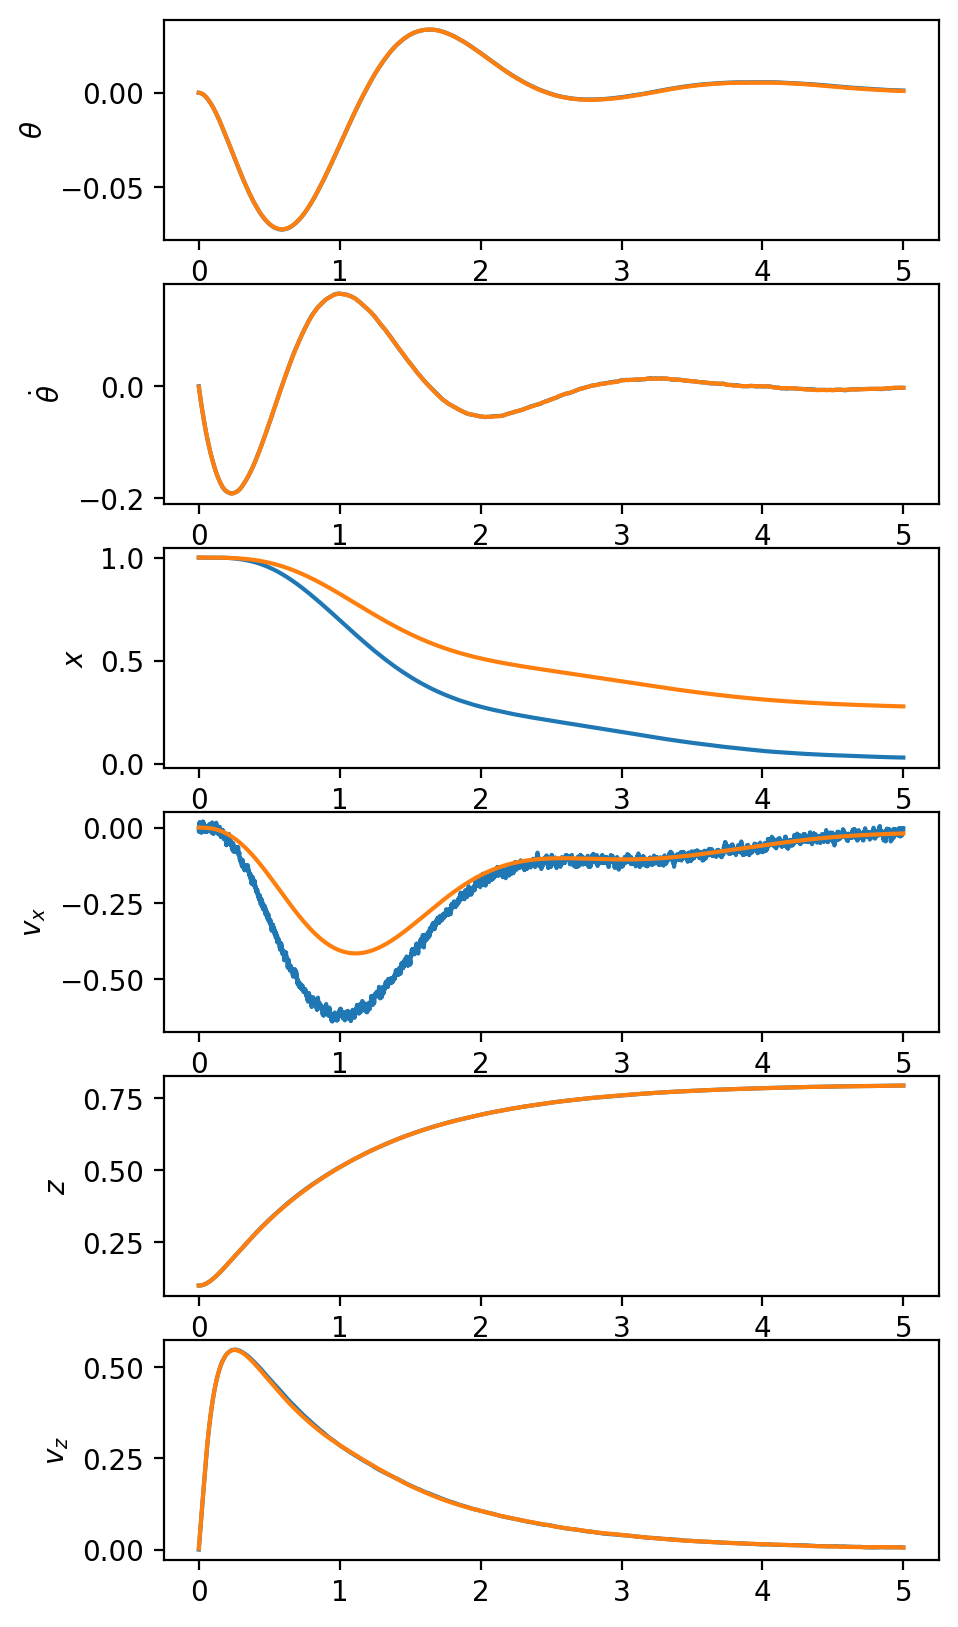

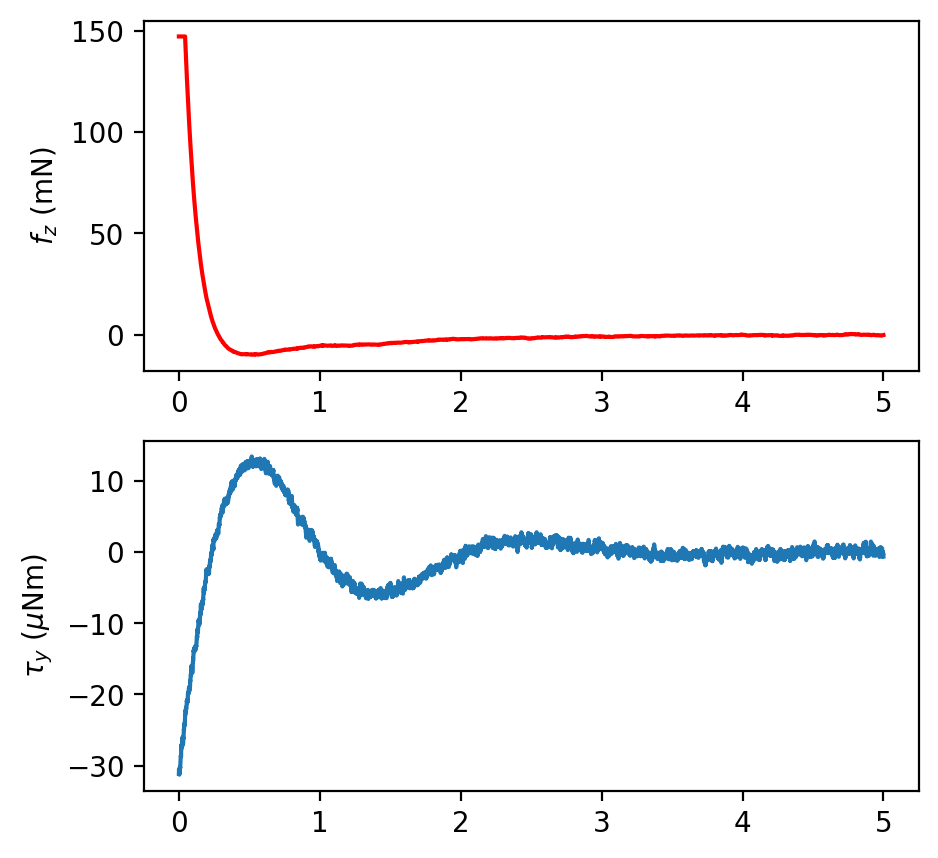

In [15]:
plt.figure(figsize=(5,10))
ylabels = (r'$\theta$', r'$\dot\theta$', r'$x$', r"$v_x$", r'$z$', r"$v_z$")
for idx in range(6):
    plt.subplot(6,1,idx+1)
    plt.plot(time, qhat_data[:,idx], time, q_data[:,idx])
    plt.ylabel(ylabels[idx])

plt.figure(figsize=(5,5))
f_z, tau_y = u_data.T
ylabels = (r'$f_z$ (mN)', r'$\tau_y$ ($\mu$Nm)')
plt.subplot(2,1,1)
plt.plot(time, u_data[:,0]*1e3, 'r')
plt.ylabel(ylabels[0])
plt.subplot(2,1,2)
plt.plot(time, u_data[:,1]*1e6)
plt.ylabel(ylabels[1]);

The velocity of crazyflie in x-direction is very noisy and highly error-prone with lags compared to velocity in z-direction as indicated by the vx and vz plots above. The estimated trajectory in x-direction has phase delay with actual trajectory but trajectory than estimated z-direction follows the actual trajectory.

Case 3: When starting from below, overestimation of lateral velocity occurs as the quadrotor is closer to the surface than the linearization assumes, so optic flow is higher. When starting from above, underestimation of lateral velocity happens, resulting in less moving estimate than it actually has. 

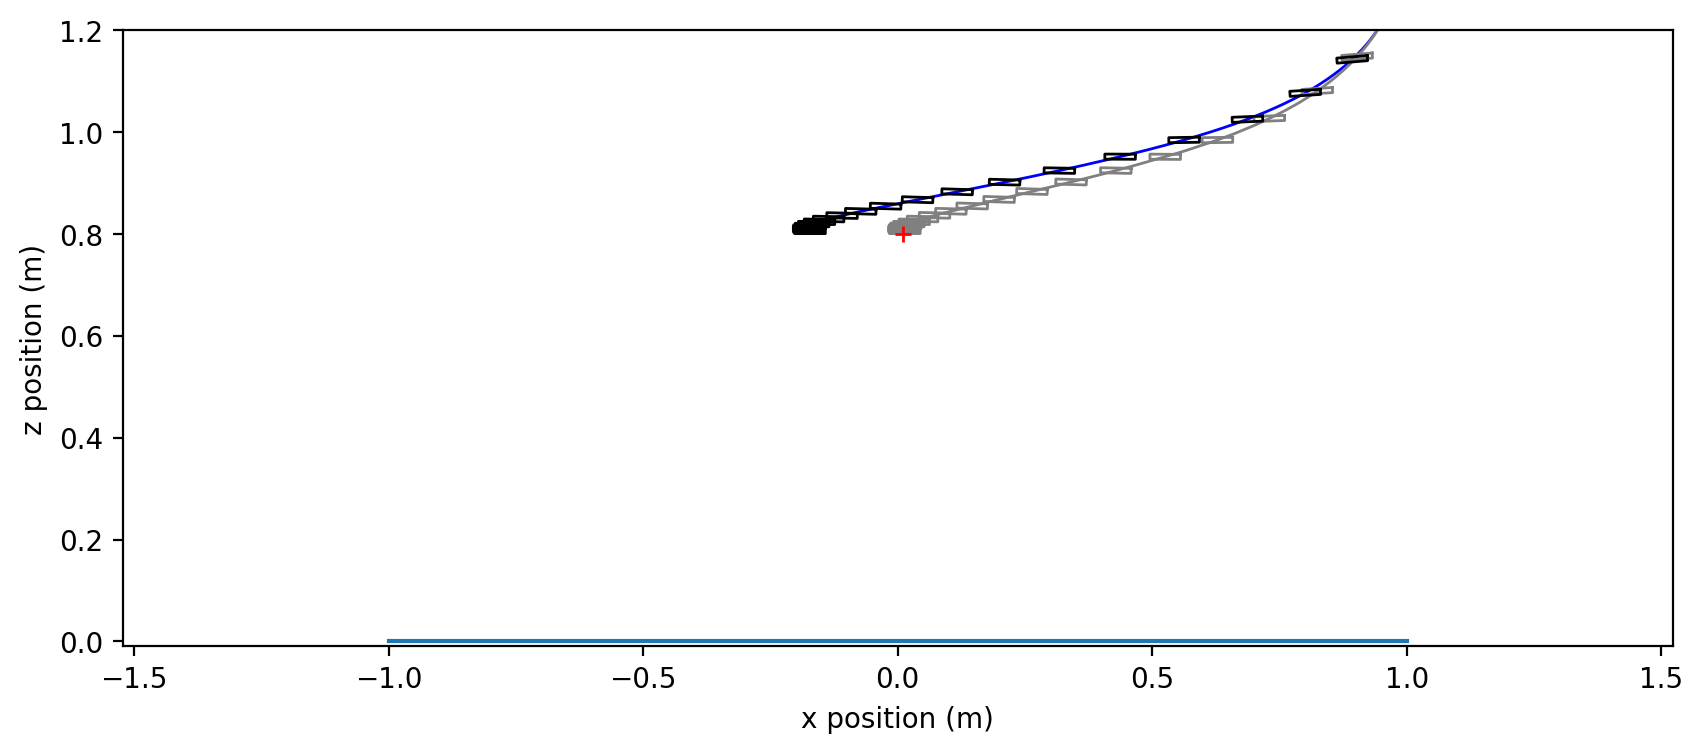

In [16]:
# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag([p.m, p.m, p.J])**2/100 # [fx, fz, tauy]
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

# initialize state and data logs 
q = np.array([0, 0, 1, 0, 1.5, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    y = sensor_model(q, p)
    qhat = qhat + dt * (A @ qhat + B @ u + L @ (y - C @ qhat))
    #u = lqr_controller(q, p, t)
    u = lqr_controller(qhat, p, t)
    q = q + dt * dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

Extended Kalman Filter can be a solution which is more accurate for systems with significant nonlinearities as above.

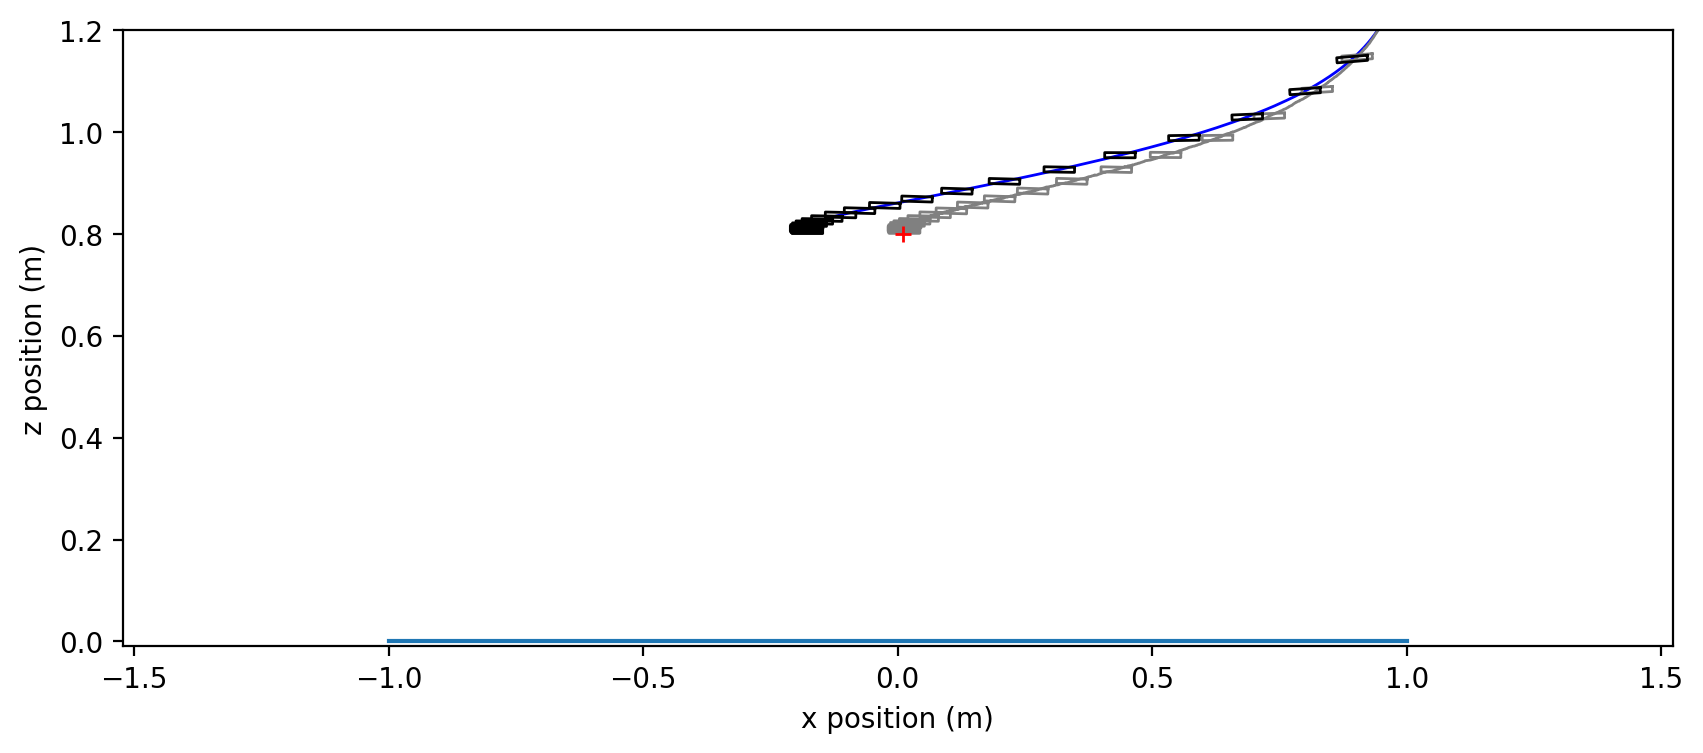

In [18]:
# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag([p.m, p.m*100, p.J])**2/100 # [fx, fz, tauy]
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

# initialize state and data logs 
q = np.array([0, 0, 1, 0, 1.5, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    y = sensor_model(q, p)
    qhat = qhat + dt * (A @ qhat + B @ u + L @ (y - C @ qhat))
    #u = lqr_controller(q, p, t)
    u = lqr_controller(qhat, p, t)
    q = q + dt * dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

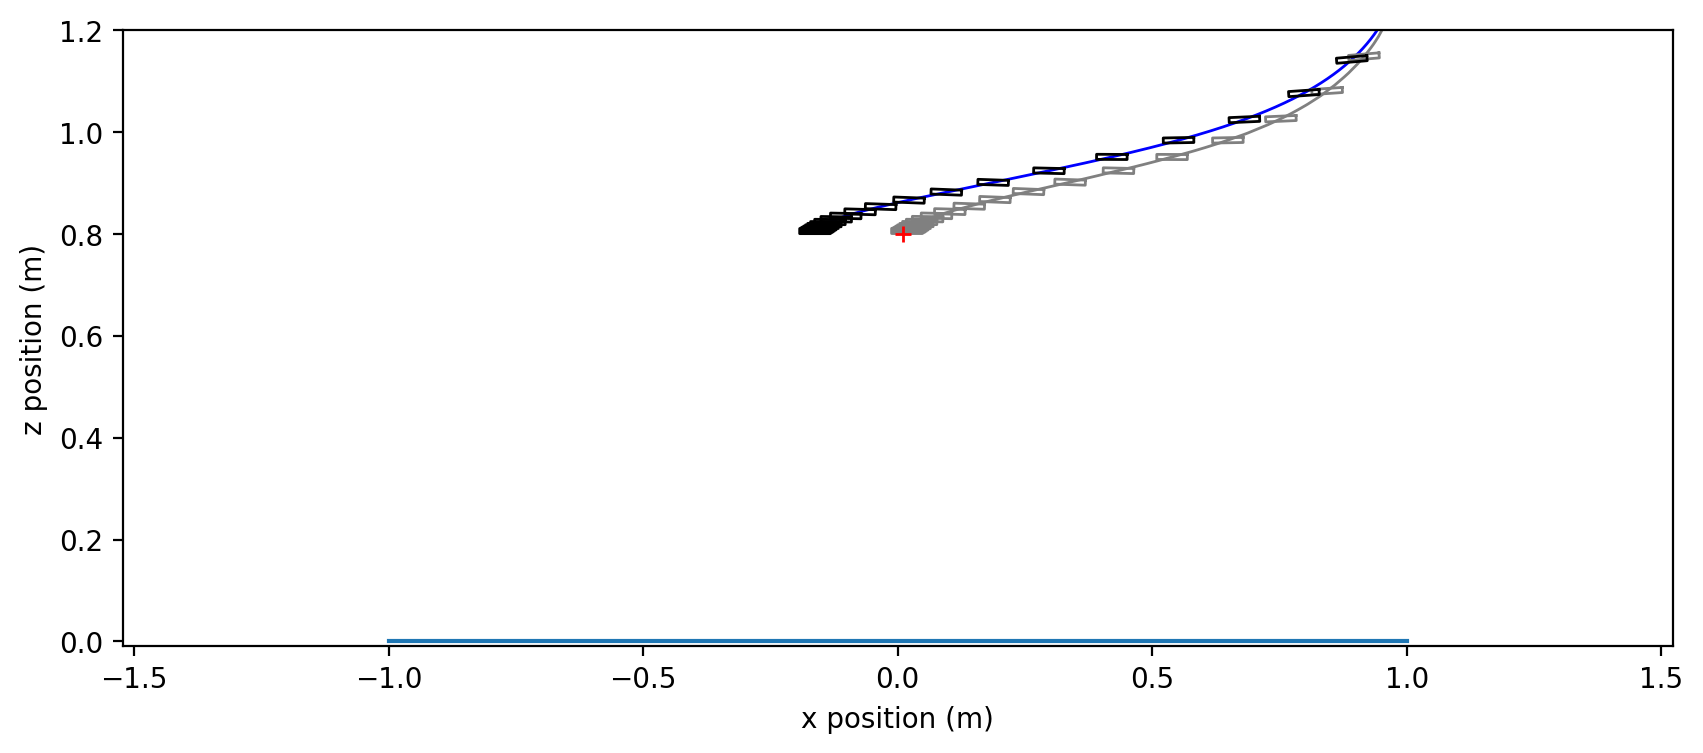

In [19]:
# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag([p.m*100, p.m, p.J])**2/100 # [fx, fz, tauy]
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

# initialize state and data logs 
q = np.array([0, 0, 1, 0, 1.5, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    y = sensor_model(q, p)
    qhat = qhat + dt * (A @ qhat + B @ u + L @ (y - C @ qhat))
    #u = lqr_controller(q, p, t)
    u = lqr_controller(qhat, p, t)
    q = q + dt * dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

Higher z process noise seems to have little deviation from the previous system with higher starting point while higher x process noise has higher deviations from the actual system compared with higher z noise.

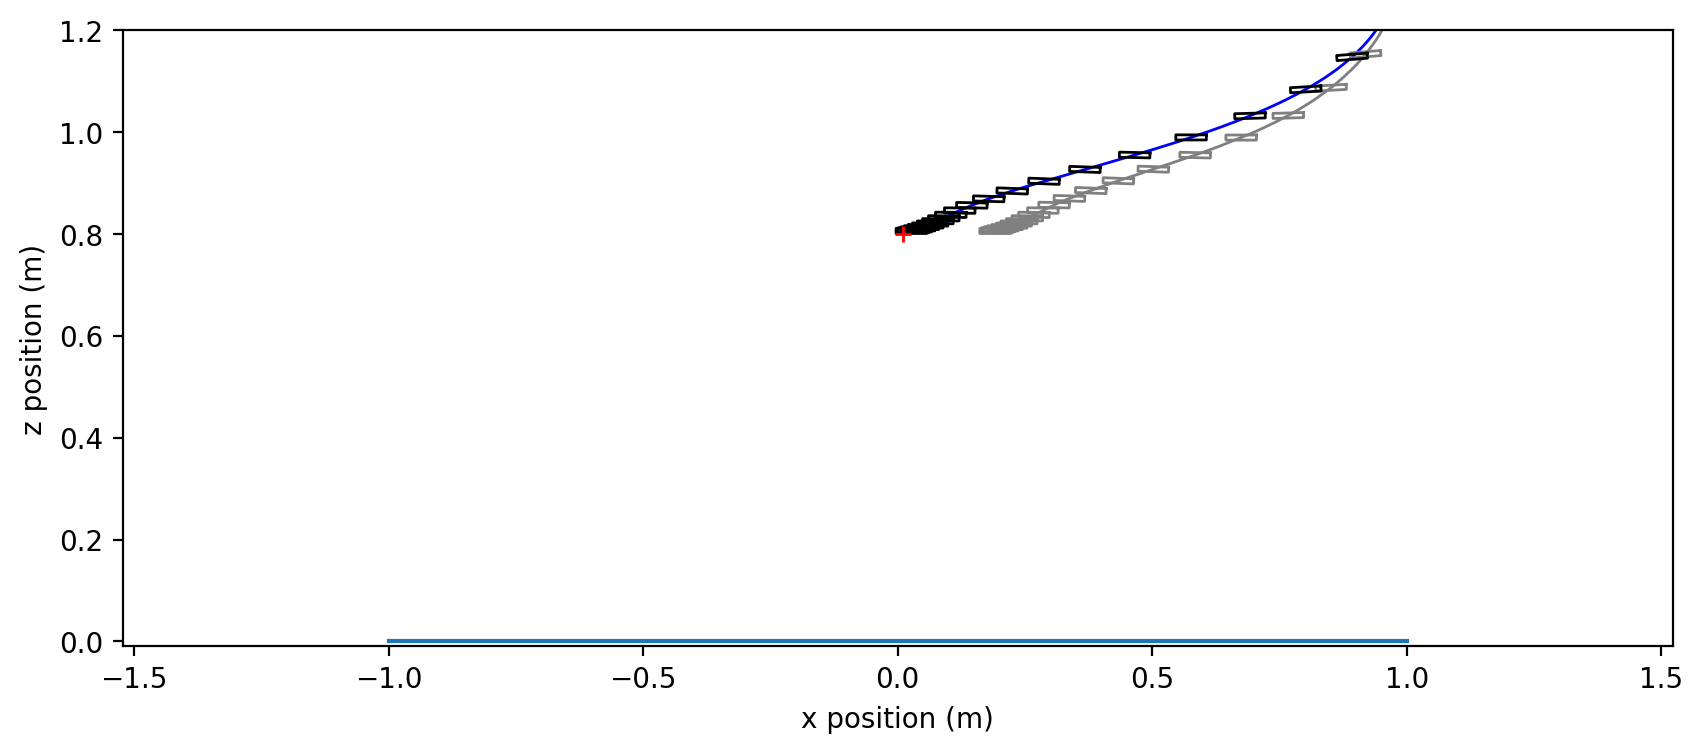

In [20]:
# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag([p.m*100, p.m, p.J])**2/100 # [fx, fz, tauy]
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
L = np.vstack((L[:2,:], [0,0,0], L[2:,:])) # add a row of zeros to L matrix

# initialize state and data logs 
q = np.array([0, 0, 1, 0, 1.5, 0]) # [thetay, omegay, x, vx, z, vz]
u = np.array([0, 0])
qhat = q # initialize estimate
t_final = 5
time = np.arange(0,t_final,dt) 
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))
y_data = np.zeros((len(time), 3))
qhat_data = np.zeros((len(time), len(q)))

# simulate
for idx, t in enumerate(time):
    y = sensor_model(q, p)
    qhat = qhat + dt * (A @ qhat + B @ u + L @ (y - C @ qhat))
    #u = lqr_controller(q, p, t)
    u = lqr_controller(q, p, t)
    q = q + dt * dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q
    y_data[idx,:] = y
    qhat_data[idx,:] = qhat
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
plt.plot(qhat_data[:,2], qhat_data[:,4], 'grey', lw=1) # trajectory
for q in qhat_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p, color='grey')
for q in q_data[::int(0.2/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

When q is used instead of qhat, their estimation deviates from its target path but the actual path reaches the target.